# AP-1 Figures

In [ ]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/home/jenhan/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Functions

In [ ]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    print('total:',features.shape[0], 'filtered:',filtered_features.shape[0], 'true gc:',np.round(true_gc_content,5), 'false gc:', np.round(false_gc_content,5), 'difference:',np.round(abs(true_gc_content - false_gc_content),5))

#     training_features, test_features, training_labels, test_labels = train_test_split(
#         filtered_features, filtered_labels, 
#         test_size =test_size, 
#         random_state=np.random.RandomState(0),
#         )
    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    
#     n_samples = filtered_features.shape[0]
#     n_features = filtered_features.shape[1]

#     # shuffle and split training and test sets
#     filtered_features, filtered_labels = shuffle(filtered_features, filtered_labels, random_state=np.random.RandomState(0))
#     split = int(0.80*n_samples)
#     training_features, test_features = filtered_features[:split], filtered_features[split:]
#     training_labels, test_labels = filtered_labels[:split], filtered_labels[split:]
    
    return training_features, test_features, training_labels, test_labels
    

## Read in Score Files

In [ ]:
motif_score_frame=pd.read_pickle('motif_score_frame.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
scaler = preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())


### read in sequences as dictionary {peakID: sequence}
with open('./group/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [ ]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [ ]:
ap1_members=['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

## Figure 1 - AP-1 genetically co-localizes with PU-1 and CEBPa

### 1a - Venn diagram of PU-1, CEBPa, and AP-1 (all members merged) in vehicle and KLA

In [ ]:
ap1_members=['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb', 'jund']

In [ ]:
ap1_indices = summary_frame[summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0].index.values
pu1_indices = summary_frame[summary_frame['c57bl6_pu1_veh'] >0].index.values
cebpa_indices = summary_frame[summary_frame['c57bl6_cebpa_veh']>0].index.values

matplotlib_venn.venn3([set(ap1_indices), set(pu1_indices), set(cebpa_indices)],set_labels=['AP-1', 'PU-1', 'CEBPa'])
plt.title('AP-1 binding overlap with PU-1 and CEBPa in Vehicle')

### 1b -  Motif analysis of PU-1, CEBPa, and AP-1 peaks. Bar plots showing what fraction of the peaks for each factor contain the PU-1, CEBPa, and AP-1 motif

In [ ]:
ap1_members=['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb', 'jund']



In [ ]:
threshold = 0.3
ap1_indices = summary_frame[summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0].index.values
pu1_indices = summary_frame[summary_frame['c57bl6_pu1_veh'] >0].index.values
cebpa_indices = summary_frame[summary_frame['c57bl6_cebpa_veh']>0].index.values

fractions = []
motifs = []
factors = []
for motif in ['ap-1', 'cebp', 'spi1-c']:
    motifs = motifs +[motif] * 3
    
    factors.append('AP-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(ap1_indices)][motif] > threshold)/len(ap1_indices))
    factors.append('CEBPa')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(cebpa_indices)][motif] > threshold)/len(cebpa_indices))
    factors.append('PU-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(pu1_indices)][motif] > threshold)/len(pu1_indices))
plottingFrame =pd.DataFrame({'Factor':factors,
                           'Motif':motifs,
                            'Fraction of all Peaks':fractions})
sns.factorplot(data=plottingFrame, 
               x='Factor', 
               hue='Motif', 
               y='Fraction of all Peaks',
              kind='bar'
              )
plt.ylim(0,1)
plt.title('Fraction of Peaks Containing Motif of Collaborating Factor')

In [ ]:
threshold = 0.3
ap1_indices = summary_frame[summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0].index.values
pu1_indices = summary_frame[summary_frame['c57bl6_pu1_veh'] >0].index.values
cebpa_indices = summary_frame[summary_frame['c57bl6_cebpa_veh']>0].index.values
open_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in _factors +['atac']]].sum(axis=1)>0].index.values
fractions = []
motifs = []
factors = []
for motif in ['ap-1', 'cebp', 'spi1-c']:
    motifs = motifs +[motif] * 4
    
    factors.append('AP-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(ap1_indices)][motif] > threshold)/len(ap1_indices))
    factors.append('CEBPa')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(cebpa_indices)][motif] > threshold)/len(cebpa_indices))
    factors.append('PU-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(pu1_indices)][motif] > threshold)/len(pu1_indices))
    factors.append('Open Chromatin')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(open_indices)][motif] > threshold)/len(open_indices))

    
plottingFrame =pd.DataFrame({'Factor':factors,
                           'Motif':motifs,
                            'Fraction of all Peaks':fractions})
sns.factorplot(data=plottingFrame, 
               x='Factor', 
               hue='Motif', 
               y='Fraction of all Peaks',
              kind='bar'
              )
plt.ylim(0,1)
plt.title('Fraction of Peaks Containing Motif of Collaborating Factor')

### 1c - Knockdown of of cJun impacts PU-1 and CEBPa binding. Venn diagrams showing overlap between knockdown and wildtype peaks in vehicle and KLA.

In [ ]:
%%bash
makeSummaryFile.sh /home/jenhan/analysis/ap1_analysis/peak_files_knockdowns_filtered/*Veh*tsv
mv group_summary.tsv knockdown_summary.tsv

In [ ]:
knockdown_summary_frame = pd.read_csv('knockdown_summary.tsv', sep='\t')

In [ ]:
notx_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('CEBPa_Veh_notx')].index.values
siCtrl_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('CEBPa_Veh_siCtrl')].index.values
siJun_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('CEBPa_Veh_siJun')].index.values

matplotlib_venn.venn3([set(notx_indices), set(siCtrl_indices), set(siJun_indices)],set_labels=['No Treatment', 'siControl', 'siJun'])
plt.title('Effect of Jun Knockdown on CEBPa binding')

In [ ]:
notx_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('PU1_Veh_notx')].index.values
siCtrl_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('PU1_Veh_siCtrl')].index.values
siJun_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('PU1_Veh_siJun')].index.values

matplotlib_venn.venn3([set(notx_indices), set(siCtrl_indices), set(siJun_indices)],set_labels=['No Treatment', 'siControl', 'siJun'])
plt.title('Effect of Jun Knockdown on PU1 binding')

### 1d - expression of Jun, pu-1 and cebpa in vehicle under knockdown conditions

In [ ]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  /home/jenhan/analysis/ap1_analysis/tag_directories_rna/* >rpkm.tsv



In [ ]:
with open('rpkm.tsv') as f:
    data=f.readlines()
header = data[0].strip()

conditions = ' '.join(['_'.join(x.split('/')[-1].replace(' FPKM','').split('_')[3:5]) for x in header.split('\t')[8:]])

In [ ]:
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv ./rna_idr $conditions -p
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv ./rna_idr $conditions

In [ ]:
idr_rpkm_frame = pd.read_csv('rna_idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = '_'.join(columns[i].split('/')[-1].split('_')[3:5])
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence'].values]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values

idr_rpkm_mean_frame = pd.DataFrame()

for treatment in idr_rpkm_frame.columns.values[8:-1]:
    if len(idr_rpkm_frame[treatment].shape) > 1:
        idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment], axis=1)



In [ ]:
plottingFrame = pd.DataFrame(idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(
            ['ATF3', 'JUN', 'FOS', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA'])].stack())
plottingFrame['Factor'] = [x[0] for x in plottingFrame.index.values]
plottingFrame['Treatment'] = [x[1] for x in plottingFrame.index.values]
plottingFrame.columns = ['RPKM', 'Factor', 'Treatment']
plottingFrame['Log2 RPKM'] = np.log2(plottingFrame['RPKM'].values + 1)
sns.factorplot(data = plottingFrame, x='Factor', y='Log2 RPKM', hue='Treatment', kind='bar', 
               hue_order=['Veh_UT','Veh_siCtrl', 'Veh_sicJun'], 
               order = ['ATF3', 'JUN', 'FOS', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA']
              )
plt.title('RNA Expression of AP-1 and Related Factors')
plt.xticks(rotation=90)

### 1e - IP of cJun and PU-1 and CEBPa

Greg will do science stuff

## Figure 2 - Introduce the AP-1 Cistrome

### 2a -  Number of peaks before and after KLA treatment for PU.1, CEBPa, p65, AP-1



In [ ]:
kla_factors = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund', 'cebpa', 'pu1', 'p65']


In [ ]:
treatments = []
factors = []
peakCounts = []
for factor in kla_factors:
    treatments = treatments + ['Lost', 'Unchanged', 'Gained']
    factors = factors + [factor] * 3
    peakCounts.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')) & 
                                    ([not x for x in summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla')])
                                   ].shape[0])
    peakCounts.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')) & 
                                    (summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla'))].shape[0])
    peakCounts.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla')) & 
                                    ([not x for x in summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')])
                                   ].shape[0])   
plottingFrame = pd.DataFrame({'Factor':factors,
                             'Change after KLA Treatment': treatments,
                             'Number of Peaks': peakCounts})
sns.factorplot(data=plottingFrame, 
               x='Factor',
              y='Number of Peaks',
              hue='Change after KLA Treatment',
              kind='bar')
plt.title('Cistrome Change in Response to KLA')
plt.xticks(rotation=90)

In [ ]:
treatments = []
factors = []
fractions = []
for factor in ['atf3', 'cjun', 'fos', 'fra1','fra2','jdp2', 'junb', 'jund', 'cebpa', 'pu1', 'p65', 'ap-1']:
    treatments = treatments + ['Vehicle', 'KLA']
    factors = factors + [factor] * 2
    fractions.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh'))].shape[0]/summary_frame.shape[0])
    fractions.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla'))].shape[0]/summary_frame.shape[0])   
plottingFrame = pd.DataFrame({'Factor':factors,
                             'Treatment': treatments,
                             'Fraction of Cistrome': fractions})
sns.factorplot(data=plottingFrame, 
               x='Factor',
              y='Fraction of Cistrome',
              hue='Treatment',
              kind='bar')
plt.title('Fractional Cistrome Occupancy')
plt.xticks(rotation=90)

### 2b - Expression of AP-1 family members

In [ ]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  /home/jenhan/analysis/ap1_analysis/tag_directories_rna/*UT*/> rpkm.tsv

%%bash
python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv ./rna_idr KLA KLA Veh Veh

In [ ]:
idr_rpkm_frame = pd.read_csv('rna_idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = '_'.join(columns[i].split('/')[-1].split('_')[3:5])
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence'].values]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values

idr_rpkm_mean_frame = pd.DataFrame()

for treatment in idr_rpkm_frame.columns.values[8:-1]:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment].astype(float), axis=1)

In [ ]:
plottingFrame = pd.DataFrame(idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(
            ['ATF3', 'JUN', 'FOS', 'FOSL1', 'FOSL2' ,'JDP2', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA'])].stack())
plottingFrame['Factor'] = [x[0] for x in plottingFrame.index.values]
plottingFrame['Treatment'] = [x[1] for x in plottingFrame.index.values]
plottingFrame.columns = ['RPKM', 'Factor', 'Treatment']
plottingFrame['Log2 RPKM'] = np.log2(plottingFrame['RPKM'].values + 1)
sns.factorplot(data = plottingFrame, x='Factor', y='Log2 RPKM', hue='Treatment', kind='bar', 
               hue_order=['Veh_UT','KLA-1h_UT'], 
               order = ['ATF3', 'JUN', 'FOS', 'FOSL1', 'FOSL2' ,'JDP2', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA']
              )
plt.title('RNA Expression of AP-1 and Related Factors')
plt.xticks(rotation=90)


### 2c -  Overlap between all peaks before and after KLA treatment - heatmap (simpler) or clustermap (shows more than pairwise interactions). Or Karnaugh Map - what has to be emphasized is that while there are 2 clusters of PU-1 peaks - with and without AP-1. There are distinct subsets of AP-1 members

In [ ]:
ap1_members=['atf3', 'cjun', 'fos', 'fra1','fra2','jdp2', 'junb', 'jund']

In [ ]:
### hierarchically cluster peaks in vehicle conditions and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))

indices = summary_frame[(summary_frame['Factors'].str.contains('_veh'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_veh' in x and not 'atac' in x]]
# data = data[data.max(axis=1) > 0.0]
data = data[data[['c57bl6_'+x+'_veh' for x in ap1_members]].max(axis=1) > 0.0]
data = data[['c57bl6_'+x+'_veh' for x in ['atf3', 'cjun', 'fos', 'fra1','fra2','jdp2', 'junb', 'jund', 'pu1','cebpa','p65']]]


logged_data = np.log2(data+1)

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Blues',
          col_cluster=False)



In [ ]:
### hierarchically cluster peaks in KLA condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame[(summary_frame['Factors'].str.contains('_kla'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_kla' in x and not 'atac' in x]]
# data = data[data.max(axis=1) > 0.0]
data = data[data[['c57bl6_'+x+'_kla' for x in ap1_members]].max(axis=1) > 0.0]
data = data[['c57bl6_'+x+'_kla' for x in ['atf3', 'cjun', 'fos', 'fra1','fra2','jdp2', 'junb', 'jund', 'pu1','cebpa','p65']]]
logged_data = np.log2(data+1)

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Reds',
          col_cluster=False)


In [ ]:
data = summary_frame[[x for x in summary_frame.columns if 'c57bl6' in x]]

data = data[data[['c57bl6_'+x+'_veh' for x in ap1_members]+['c57bl6_'+x+'_kla' for x in ap1_members]].max(axis=1) > 0.0]

veh_data = data[[x for x in data.columns if '_veh' in x and not 'atac' in x]]
kla_data = data[[x for x in data.columns if '_kla' in x and not 'atac' in x]]

fold_frame = np.log2(pd.DataFrame((kla_data.values+1)).divide((veh_data.values+1)))
fold_frame.columns = [x.replace('_kla','').replace('c57bl6_','') for x in data.columns if '_kla' in x and not 'atac' in x]

In [ ]:
cg = sns.clustermap(fold_frame[['atf3', 'cjun', 'fos', 'fra1','fra2','jdp2', 'junb', 'jund', 'pu1','cebpa','p65']],
          yticklabels=False,
          xticklabels=True,
          col_cluster=False,
          vmin = -4,
          vmax = 4,          
          cmap='coolwarm')

In [ ]:
### hierarchically cluster peaks in KLA condition and do de novo motif analysis on each cluster ###
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame.index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
# data = data[data[['c57bl6_'+x+'_kla' for x in ap1_members]].max(axis=1) > 0.0]
# data = data[['c57bl6_'+x+'_kla' for x in ['atf3','cjun','fos','junb','jund','pu1','cebpa','p65']]]
logged_data = np.log2(data+1)

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          col_cluster=False)



### overlap as heatmap

In [ ]:
# get peak IDS for peaks
factor_index_dict_veh = {}
factor_index_dict_kla = {}

for f in _factors:
    indices = summary_frame[summary_frame['c57bl6_'+f+'_veh'] > 0].index.values
    factor_index_dict_veh[f] = set(indices)
    
for f in _factors:
    indices = summary_frame[summary_frame['c57bl6_'+f+'_kla'] > 0].index.values
    factor_index_dict_kla[f] = set(indices)
    
matrix = np.zeros((len(_factors), len(_factors)))
for i in range(len(_factors) - 1):
    for j in range(i+1, len(_factors)):
        factor1 = _factors[i]
        factor2 = _factors[j]
        overlap_veh = factor_index_dict_veh[factor1].intersection(factor_index_dict_veh[factor2])
        overlap_kla = factor_index_dict_kla[factor1].intersection(factor_index_dict_kla[factor2])
        matrix[i][j] = len(overlap_veh)
        matrix[j][i] = len(overlap_kla)
    

In [ ]:
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    sns.heatmap(matrix, 
                xticklabels=_factors, 
                yticklabels=_factors,
                vmax=10000,
                cmap = 'Blues')


with sns.axes_style("white"):
    cg =sns.heatmap(matrix, 
                xticklabels=_factors, 
                yticklabels=_factors,
                mask=mask,
                vmax=10000,
                cmap = 'Reds')
plt.setp(cg.axes.yaxis.get_majorticklabels(), rotation=0)


plt.title('Overlap of Binding Sites')



### overlap as chow ruskey diagram

In [ ]:
# ### generate R code for chow-ruskey diagram ###
# veh_script = open('veh_chowRuskey_script.R','w')
# veh_script.write('library(Vennerable);\n')
# # get peak IDS for peaks
# for f in _factors:
#     indices = summary_frame[summary_frame['c57bl6_'+f+'_veh'] > 0].index.values
#     veh_script.write(f + '_ids <- list(' + ','.join(["'"+x+"'" for x in indices]) + ');\n')
#     veh_script.write(f+'_ids.name <-"'+f+'";\n')
# #     print(f + '_ids <- list(' + ','.join(['"'+x+'"' for x in indices]) + ');')
# veh_script.write('veh_ids <- list(' + ','.join([x+'_ids' for x in _factors]) + ');\n')
# veh_script.write('veh_venn_object <- Venn(veh_ids);\n')
# veh_script.write('pdf("veh_chowRuskey.pdf")\n')
# veh_script.write('plot(veh_venn_object,type="ChowRuskey")\n')
# veh_script.write('dev.off()')
# veh_script.close()

In [ ]:
# ### generate R code for chow-ruskey diagram ###
# veh_script = open('kla_chowRuskey_script.R','w')
# veh_script.write('library(Vennerable);\n')
# # get peak IDS for peaks
# for f in _factors:
#     indices = summary_frame[summary_frame['c57bl6_'+f+'_kla'] > 0].index.values
#     veh_script.write(f + '_ids <- list(' + ','.join(["'"+x+"'" for x in indices]) + ');\n')
#     veh_script.write(f+'_ids.name <-"'+f+'";\n')
# #     print(f + '_ids <- list(' + ','.join(['"'+x+'"' for x in indices]) + ');')
# veh_script.write('kla_ids <- list(' + ','.join([x+'_ids' for x in _factors]) + ');\n')
# veh_script.write('kla_venn_object <- Venn(kla_ids);\n')
# veh_script.write('pdf("kla_chowRuskey.pdf")\n')
# veh_script.write('plot(kla_venn_object,type="ChowRuskey")\n')
# veh_script.write('dev.off()')
# veh_script.close()

## Figure 3 - Motifs that coordinate binding of individual factors

### 3a - workflow of motif analysis pipeline and prediction scheme

### 3b - Predictive performance for each factor (bar plot). Or a heatmap (1 axis shows the fraction of samples used for training, the other axis shows each factor, color shows predictive ability)

In [ ]:
### test predictive ability with different test fraction sizes
factor_auc_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in [x for x in _factors if not 'atac' in x]:
    factor_auc_dict[factor] = []
    print(factor)
    for test_size in [0.1, 0.5, 0.9]:#np.arange(0.1,1.0,0.1):
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)


        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)
        print('test fraction:',test_size, 'num training features', len(training_features), 'num test features', len(test_features))


        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
      
        fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        factor_auc_dict[factor].append(roc_auc_lr)

auc_frame = pd.DataFrame(factor_auc_dict)
auc_frame.index = [0.1, 0.5, 0.9]#np.arange(0.1,1.0,0.1)

In [ ]:
stacked_frame = pd.DataFrame(auc_frame.stack())
stacked_frame['Factor'] = [x[1] for x in stacked_frame.index.values]
stacked_frame['Training Fraction'] = [np.round(1- x[0],3) for x in stacked_frame.index.values]
stacked_frame.columns = ['AUC', 'Factor', 'Training Fraction']
stacked_frame.index = range(stacked_frame.shape[0])
with sns.axes_style('whitegrid'):
    sns.factorplot(data=stacked_frame[stacked_frame['Training Fraction'].isin([0.1,0.5, 0.9])], 
                   x='Factor', y='AUC', hue='Training Fraction', size=10, kind='bar', palette='Blues')
    plt.ylim(0,1)
    plt.title('Classifier Performance with Different Training Set Sizes')

### 3c - Weights for all peaks (vehicle or KLA done seperately) as a heatmap, showing which motifs are important for each factor

In [ ]:
### for all peaks in vehicle 
factor_coeff_dict = {}
factor_auc_dict_all = {}
factor_intercept_dict_veh = {}

# factors = ['atf3', 'cjun', 'jund','cebpa', 'pu1']
# factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
factors = ['ap-1', 'cebpa', 'pu1', 'p65']
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values

for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_veh')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    
    factor_intercept_dict_veh[factor] = lr_classifier.intercept_
    print(factor, roc_auc)
    
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh = coefficients_frame_veh[factors]
coefficients_frame_veh.index = normed_motif_frame.columns.values


In [ ]:
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_veh = set()
for factor in coefficients_frame_veh.columns.values:
    weights = coefficients_frame_veh[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_veh.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

In [ ]:
threshold = 2.5
coeff_std = np.std(coefficients_frame_veh.values.flatten())
coeff_mean = np.mean(coefficients_frame_veh.values.flatten())
cg = sns.clustermap(coefficients_frame_veh[coefficients_frame_veh.index.isin(significant_motifs_veh)],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 8},
                    col_cluster=False
                )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [ ]:
### for all peaks in kla 
factor_coeff_dict = {}
factor_auc_dict_all = {}

# factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
factors = ['ap-1', 'cebpa', 'pu1', 'p65']
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_kla' for x in factors]].sum(axis=1) > 0].index.values


for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_kla')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla = coefficients_frame_kla[factors]
coefficients_frame_kla.index = normed_motif_frame.columns.values







In [ ]:
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_kla = set()
for factor in coefficients_frame_kla.columns.values:
    weights = coefficients_frame_kla[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits
#     sns.distplot(weights)
#     for pos in [mean, mean-std, mean+std, mean+2*std, mean-2*std]:
#         plt.axvline(pos)
#     plt.title(factor)
    
#     plt.show()
#     print(factor)

In [ ]:
threshold = 2.5
coeff_std = np.std(coefficients_frame_kla.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla.values.flatten())
cg = sns.clustermap(coefficients_frame_kla[coefficients_frame_kla.index.isin(significant_motifs_kla)],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 8},
                   col_cluster=False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

### 3d - boxplots of motif scores for the important motifs? Motif Distance Plots?

In [ ]:
### motif distance plots for veh peaks ###
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
for factor in coefficients_frame_veh.columns.values:
    weights = coefficients_frame_veh[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits
    
colorDict = dict(zip(range(10), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))
for factor in coefficients_frame_veh.columns.values:
    positive_motifs = sorted(factor_motifs_positive_dict[factor])
    negative_motifs = sorted(factor_motifs_negative_dict[factor])
    for i in range(len(positive_motifs)):
        motif = positive_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor + '_veh')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-1000)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i])
    for i in range(len(negative_motifs)):
        motif = negative_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor+'_veh')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-1000)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i+len(positive_motifs)], linestyle='--')        
    recs = []
    for i in range(0,len(positive_motifs + negative_motifs)):
        recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=colorDict[i]))
    plt.legend(recs,positive_motifs + negative_motifs,loc='upper right')
    plt.xlim(-500,500)
    plt.ylabel('KDE')
    plt.xlabel('Distance to ' + factor +' Peak Center')
    plt.title('Motif Distance to '+factor +' Peak')
    plt.show()

In [ ]:
### motif distance plots for KLA peaks ###
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_kla = set()
for factor in coefficients_frame_kla.columns.values:
    weights = coefficients_frame_kla[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

colorDict = dict(zip(range(10), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))
for factor in coefficients_frame_kla.columns.values:
    positive_motifs = sorted(factor_motifs_positive_dict[factor])
    negative_motifs = sorted(factor_motifs_negative_dict[factor])
    for i in range(len(positive_motifs)):
        motif = positive_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor+'_kla')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-1000)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i])
    for i in range(len(negative_motifs)):
        motif = negative_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor+'_kla')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-1000)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i+len(positive_motifs)], linestyle='--')        
    recs = []
    for i in range(0,len(positive_motifs + negative_motifs)):
        recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=colorDict[i]))
    plt.legend(recs,positive_motifs + negative_motifs,loc='upper right')
    plt.xlim(-500,500)
    plt.ylabel('KDE')
    plt.xlabel('Distance to ' + factor +' Peak Center')
    plt.title('Motif Distance to '+factor +' Peak')
    plt.show()

### 3e - strains confirmation



#### Vehicle

In [ ]:
motif_balbcj_snp_frame = pd.read_pickle('./motif_balbcj_snp_frame.pickle')
motif_nod_snp_frame = pd.read_pickle('./motif_nod_snp_frame.pickle')

In [ ]:
### for all peaks in vehicle 
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('veh'))].index.values
factors = ['atf3', 'cjun', 'jund','cebpa', 'pu1']
# factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
# factors = ['ap-1', 'cebpa', 'pu1', 'p65']
for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_veh')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh = coefficients_frame_veh[factors]
coefficients_frame_veh.index = normed_motif_frame.columns.values

In [ ]:
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
for factor in coefficients_frame_veh.columns.values:
    weights = coefficients_frame_veh[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

In [ ]:
strains_factors = ['pu1',
#                    'fos',
                   'cjun',
#                    'junb',
                   'jund',
                   'pu1']
strains = ['balbc', 'nod']
treatments = ['veh']

strain_list = []
factor_list = []
binding_list = []
binding_ratio_list = []

for strain in strains:
    for factor in strains_factors:
        for treatment in treatments:
            print(strain, factor, treatment)
            strain_factor_treatment_1 = 'c57bl6'+'_'+factor+'_'+treatment
            strain_factor_treatment_2 = strain+'_'+factor+'_'+treatment
            indices = summary_frame[(summary_frame['Factors'].str.contains(strain_factor_treatment_1)) |
                                   (summary_frame['Factors'].str.contains(strain_factor_treatment_2))].index.values
            
            positive_motifs = factor_motifs_positive_dict[factor]
            negative_motifs = factor_motifs_negative_dict[factor]
#             print(positive_motifs)
            threshold = max(0,len(positive_motifs))
            threshold = len(positive_motifs) -1
            if strain == 'balbcj':
                snp_indices = motif_balbcj_snp_frame[(motif_balbcj_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_balbcj_snp_frame.sum(axis=1) <=20)
                                                    ].index.values
            elif strain == 'nod':
                snp_indices = motif_nod_snp_frame[(motif_nod_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_nod_snp_frame.sum(axis=1) <= 20)].index.values

            indices = [x for x in indices if x in snp_indices]
            
            peakScores_1 = summary_frame.ix[indices,strain_factor_treatment_1]
            peakScores_2 = summary_frame.ix[indices,strain_factor_treatment_2]
            
            binding_ratios = (peakScores_1 +1)/(peakScores_2 + 1)
            log_binding_ratios = list(np.log2(binding_ratios+1))

            if len(peakScores_1) > 1:

                binding_ratio_list = binding_ratio_list + log_binding_ratios
                binding_list = binding_list +list(peakScores_1)
                binding_list = binding_list + list(peakScores_2)
                factor_list = factor_list + [factor] * 1 * len(log_binding_ratios)
#                 strain_list = strain_list + ['c57bl6']  *len(log_binding_ratios)
                strain_list = strain_list + [strain]  *len(log_binding_ratios)

In [ ]:
snp_plotting_frame = pd.DataFrame({'Factor':factor_list,
                                  'Strain':strain_list,
                                   'Log 2 Binding Ratio':binding_ratio_list}
                                  )
sns.factorplot(data = snp_plotting_frame,
               x='Factor', 
               hue='Strain',
               y='Log 2 Binding Ratio',
              kind='bar',
             )
plt.ylabel('Log 2 Binding Ratio (C57/Strain)')
plt.show()


#### KLA

In [ ]:
### for all peaks in kla 
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('kla'))].index.values
factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
# factors = ['ap-1', 'cebpa', 'pu1', 'p65']

for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_kla')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla = coefficients_frame_kla[factors]
coefficients_frame_kla.index = normed_motif_frame.columns.values


In [ ]:
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_kla = set()
for factor in coefficients_frame_kla.columns.values:
    weights = coefficients_frame_kla[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits


In [ ]:
strains_factors = ['pu1',
                   'fos',
                   'cjun',
                   'junb',
                   'jund',
                   'pu1']
strains = ['balbc', 'nod']
treatments = ['kla']

strain_list = []
factor_list = []
binding_list = []
binding_ratio_list = []

for strain in strains:
    for factor in strains_factors:
        for treatment in treatments:
            print(strain, factor, treatment)
            strain_factor_treatment_1 = 'c57bl6'+'_'+factor+'_'+treatment
            strain_factor_treatment_2 = strain+'_'+factor+'_'+treatment
            indices = summary_frame[(summary_frame['Factors'].str.contains(strain_factor_treatment_1)) |
                                   (summary_frame['Factors'].str.contains(strain_factor_treatment_2))].index.values
            
            positive_motifs = factor_motifs_positive_dict[factor]
            negative_motifs = factor_motifs_negative_dict[factor]
#             print(positive_motifs)
            threshold = max(0,len(positive_motifs))
            threshold = len(positive_motifs) -1 
            if strain == 'balbcj':
                snp_indices = motif_balbcj_snp_frame[(motif_balbcj_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_balbcj_snp_frame.sum(axis=1) <=20)
                                                    ].index.values
            elif strain == 'nod':
                snp_indices = motif_nod_snp_frame[(motif_nod_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_nod_snp_frame.sum(axis=1) <= 20)].index.values

            indices = [x for x in indices if x in snp_indices]
            
            peakScores_1 = summary_frame.ix[indices,strain_factor_treatment_1]
            peakScores_2 = summary_frame.ix[indices,strain_factor_treatment_2]
            
            binding_ratios = (peakScores_1 +1)/(peakScores_2 + 1)
            log_binding_ratios = list(np.log2(binding_ratios+1))

            if len(peakScores_1) > 1:

                binding_ratio_list = binding_ratio_list + log_binding_ratios
                binding_list = binding_list +list(peakScores_1)
                binding_list = binding_list + list(peakScores_2)
                factor_list = factor_list + [factor] * 1 * len(log_binding_ratios)
#                 strain_list = strain_list + ['c57bl6']  *len(log_binding_ratios)
                strain_list = strain_list + [strain]  *len(log_binding_ratios)

In [ ]:
snp_plotting_frame = pd.DataFrame({'Factor':factor_list,
                                  'Strain':strain_list,
                                   'Log 2 Binding Ratio':binding_ratio_list}
                                  )
sns.factorplot(data = snp_plotting_frame,
               x='Factor', 
               hue='Strain',
               y='Log 2 Binding Ratio',
              kind='bar',
             )
plt.ylabel('Log 2 Binding Ratio (C57/Strain)')
plt.show()


## Figure 4 - Motifs that coordinate pairs of transcription factors

### 4a - Workflow of motif analysis and prediction scheme


### 4c- Heatmap highlighting weights that are important for each pair of factors (collapse AP-1 for comparisons to PU-1 and CEBPa and p65)


#### comparisons to collapsed PU.1, CEBPa, and p65

#### vehicle

In [ ]:
factors = ['ap-1', 'cebpa', 'p65', 'pu1']
factorPairs = []
for i in range(len(factors)-1):
    for j in range(i+1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [ ]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('veh'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]+'_veh') & summary_frame['Factors'].str.contains(factorPair[1]+'_veh')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_pairs.index = normed_motif_frame.columns.values

In [ ]:
threshold = 2.5
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_veh_pairs = set()
for factor in coefficients_frame_veh_pairs.columns.values:
    weights = coefficients_frame_veh_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_veh_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits
#     sns.distplot(weights)
#     for pos in [mean, mean-std, mean+std, mean+2*std, mean-2*std]:
#         plt.axvline(pos)
#     plt.title(factor)
    
#     plt.show()
#     print(factor)

In [ ]:
threshold = 3
coeff_std = np.std(coefficients_frame_veh_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_veh_pairs.values.flatten())
data = coefficients_frame_veh_pairs[coefficients_frame_veh_pairs.index.isin(significant_motifs_veh_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    cg = sns.clustermap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6},
                       col_cluster=False)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

#### KLA

In [ ]:
### for all peaks in KLA for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('kla'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]+'_kla') & summary_frame['Factors'].str.contains(factorPair[1]+'_kla')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla_pairs.index = normed_motif_frame.columns.values



In [ ]:
threshold = 2.5
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_kla_pairs = set()
for factor in coefficients_frame_kla_pairs.columns.values:
    weights = coefficients_frame_kla_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits
#     sns.distplot(weights)
#     for pos in [mean, mean-std, mean+std, mean+2*std, mean-2*std]:
#         plt.axvline(pos)
#     plt.title(factor)
    
#     plt.show()
#     print(factor)



In [ ]:
threshold = 3
coeff_std = np.std(coefficients_frame_kla_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla_pairs.values.flatten())
data = coefficients_frame_kla_pairs[coefficients_frame_kla_pairs.index.isin(significant_motifs_kla_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
cg = sns.clustermap(data,
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 6},
                   col_cluster=False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

### comparisons within AP-1 dimers

In [ ]:
factors = ['atf3', 'cjun','fos', 'fra1','fra2','jdp2','junb', 'jund']
factorPairs = []
for i in range(len(factors)-1):
    for j in range(i + 1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [ ]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indicesc57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('veh'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    label_frame = summary_frame[summary_frame.index.isin(c57bl6_indices)]
    if factorPair[0] == factorPair[1]:
        labels = label_frame.ix[:,5:].sum(axis=1) == label_frame[factorPair[0] + '_veh']
    else:
        labels = label_frame['Factors'].str.contains(
        factorPair[0]+'_veh') & summary_frame['Factors'].str.contains(factorPair[1]+'_veh')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_ap1_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ap1_veh_pairs.index = normed_motif_frame.columns.values




In [ ]:
threshold = 2.5
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_ap1_veh_pairs = set()
for factor in coefficients_frame_ap1_veh_pairs.columns.values:
    weights = coefficients_frame_ap1_veh_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_ap1_veh_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits



In [ ]:
threshold = 3
coeff_std = np.std(coefficients_frame_ap1_veh_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_ap1_veh_pairs.values.flatten())
data = coefficients_frame_ap1_veh_pairs[coefficients_frame_ap1_veh_pairs.index.isin(significant_motifs_ap1_veh_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
# fig, ax = plt.subplots(figsize=(10,10))
data=data[(data.min(axis=1) <=0) & (data.max(axis=1) >= 0) ]
# data=data[(data.min(axis=1) <=0)]
with sns.axes_style('whitegrid'):
    cg = sns.clustermap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6},
                       col_cluster = False)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);

In [ ]:
factors = ['atf3', 'cjun','fos', 'fra1','fra2','jdp2','junb', 'jund']

factorPairs = []
for i in range(len(factors)-1):
    for j in range(i+1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [ ]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('kla'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]+'_kla') & summary_frame['Factors'].str.contains(factorPair[1]+'_kla')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_ap1_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ap1_kla_pairs.index = normed_motif_frame.columns.values





In [ ]:
threshold = 2.5
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_ap1_kla_pairs = set()
for factor in coefficients_frame_ap1_kla_pairs.columns.values:
    weights = coefficients_frame_ap1_kla_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_ap1_kla_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits



In [ ]:
threshold = 3
coeff_std = np.std(coefficients_frame_ap1_kla_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_ap1_kla_pairs.values.flatten())
data = coefficients_frame_ap1_kla_pairs[coefficients_frame_ap1_kla_pairs.index.isin(significant_motifs_ap1_kla_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
data=data[(data.min(axis=1) <=0) & (data.max(axis=1) >= 0) ]


# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    cg = sns.clustermap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6})
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0);
    plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8, rotation=90);

### 4d- Strains confirmations. X-axis - binding ratio between two (Balb/nod vs C57) Y-axis motif score


### 4e - crispr conformation? Knockout a loci and see that binding is disrupted (can’t be at AP-1 motif)

## Figure 5 - Motifs that drive the KLA transition

### For Individual Factors 

In [ ]:
difference_indices = (coefficients_frame_kla*coefficients_frame_veh < 0) | \
                     (coefficients_frame_kla*coefficients_frame_veh == 0)
current_coefficients_frame_kla = coefficients_frame_kla[difference_indices.sum(axis=1)>0]
current_coefficients_frame_veh = coefficients_frame_veh[difference_indices.sum(axis=1)>0]

coefficients_difference_frame = current_coefficients_frame_kla - current_coefficients_frame_veh
coefficients_difference_frame[current_coefficients_frame_veh * current_coefficients_frame_kla > 0] =0
# del coefficients_difference_frame['p65']


In [ ]:
sns.distplot(coefficients_difference_frame.values.flatten())
print(np.std(coefficients_difference_frame.values.flatten()))

In [ ]:
threshold = 2.5
significant_motifs_differences = set()
for factor in coefficients_difference_frame.columns.values:
    weights = coefficients_difference_frame[factor]
    mean=np.mean(weights)
    std = np.std(weights)
    positive_hits = list(weights[weights >= mean + threshold * std].index.values)
    negative_hits = list(weights[weights <= mean - threshold * std].index.values)
    motif_hits = negative_hits + positive_hits
    print(factor, mean, std)
    for m in motif_hits:
        significant_motifs_differences.add(m)

In [ ]:
threshold = 2.5
coeff_std = np.std(coefficients_difference_frame.values.flatten());
coeff_mean = np.mean(coefficients_difference_frame.values.flatten());
data = coefficients_difference_frame[coefficients_difference_frame.index.isin(significant_motifs_differences)];
data.columns = [x.replace('c57bl6_','') for x in data.columns.values];
# fig, ax = plt.subplots(figsize=(10,10))
cg = sns.clustermap(data,
                   vmax=mean+threshold*coeff_std,
                   vmin=mean-threshold*coeff_std,
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 6},
                    col_cluster=False
                   );
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0);

### For collaborative binding

In [ ]:
# difference_indices = (coefficients_frame_kla_pairs*coefficients_frame_veh_pairs < 0) | \
#                      (coefficients_frame_kla_pairs*coefficients_frame_veh_pairs == 0)
# current_coefficients_frame_kla = coefficients_frame_kla_pairs[difference_indices.sum(axis=1)>0]
# current_coefficients_frame_veh = coefficients_frame_veh_pairs[difference_indices.sum(axis=1)>0]

# coefficients_difference_pair_frame = current_coefficients_frame_kla - current_coefficients_frame_veh
# coefficients_difference_pair_frame[current_coefficients_frame_veh * current_coefficients_frame_kla > 0] =0
# # # del coefficients_difference_frame['p65']



In [ ]:
# sns.distplot(coefficients_difference_pair_frame.values.flatten())
# print(np.std(coefficients_difference_pair_frame.values.flatten()))

In [ ]:
# threshold = 3
# significant_motifs_differences_pair = set()
# for factor in coefficients_difference_pair_frame.columns.values:
#     weights = coefficients_difference_pair_frame[factor]
#     mean=np.mean(weights)
#     std = np.std(weights)
#     positive_hits = list(weights[weights >= mean + threshold * std].index.values)
#     negative_hits = list(weights[weights <= mean - threshold * std].index.values)
#     motif_hits = negative_hits + positive_hits
#     print(factor, mean, std)
#     for m in motif_hits:
#         significant_motifs_differences_pair.add(m)

In [ ]:
# threshold = 3
# coeff_std = np.std(coefficients_difference_pair_frame.values.flatten());
# coeff_mean = np.mean(coefficients_difference_pair_frame.values.flatten());
# data = coefficients_difference_pair_frame[coefficients_difference_pair_frame.index.isin(significant_motifs_differences_pair)];
# data.columns = [x.replace('c57bl6_','') for x in data.columns.values];
# # fig, ax = plt.subplots(figsize=(10,10))
# cg = sns.clustermap(data,
#                    vmax=mean+threshold*coeff_std,
#                    vmin=mean-threshold*coeff_std,
#                    center = coeff_mean,
#                    annot=False,annot_kws={"size": 6},
#                     col_cluster=False
#                    );
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
# # plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0);

## Motif Degeneracy

In [ ]:
steps = 10
# motifs = normed_motif_frame.columns.values
motifs = ['ap-1', 'spi1-c', 'cebp', 'rel','irf1', 'pbx1', 'znf740']
matrix = np.zeros((len(motifs), steps))
open_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in _factors +['atac']]].sum(axis=1)>0].index.values


# current_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
current_frame = normed_motif_frame
current_frame = current_frame[current_frame.index.isin(open_indices)]
totalPeaks = current_frame.shape[0]
for i in range(len(motifs)):
    motif = motifs[i]
    
    for j in range(steps):
        threshold = j/steps
        fraction = np.sum(current_frame[motif] > threshold) / totalPeaks
        matrix[i][j] = fraction




In [ ]:
fraction_frame = pd.DataFrame(matrix)
fraction_frame.index=motifs
fraction_frame.columns = np.arange(0,1,1/steps)

In [ ]:
cg = sns.clustermap(fraction_frame,
              col_cluster=False,
                    row_cluster=False,
              vmin=0,
              vmax=1,
                   annot=True)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0,
        );

## Dimer Switch 

In [ ]:
factors = ['atf3', 'cjun','fos', 'fra1','fra2','jdp2','junb', 'jund']

factorPairs = []
for i in range(len(factors)-1):
    for j in range(i+1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [ ]:
factor_coeff_dict = {}
fraction =0.5
lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
treatment = 'veh'
feature_frame = normed_motif_frame

for fp in factorPairs:
    factor_auc_dict = {}
    factor1 = fp[0] + '_' + treatment
    factor2 = fp[1] + '_' + treatment
    print(factor1,factor2)
    # all factor 1
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor1)
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict['all ' + factor1] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict['all ' + factor1] = roc_auc_lr
    
    # factor 1 only
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor1) & \
        [not x for x in summary_frame['Factors'].str.contains(factor2)]
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict[factor1 + ' only'] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict[factor1 + ' only'] = roc_auc_lr
    
    # factor 1 and factor 2
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor1) & \
        summary_frame['Factors'].str.contains(factor2)    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict[factor1 + ' and ' +factor2] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict[factor1 + ' and ' +factor2] = roc_auc_lr
    
    # factor 2 only
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor2) & \
        [not x for x in summary_frame['Factors'].str.contains(factor1)]
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict[factor2 + ' only'] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict[factor2 + ' only'] = roc_auc_lr
    
    # all factor 2
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor2)
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict['all ' + factor2] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict['all ' + factor2] = roc_auc_lr
    
    ### plot coefficents
    frame = pd.DataFrame(factor_coeff_dict)
    frame.index = features.columns.values
    frame = frame[['all ' + factor1, 
                   factor1 + ' only', 
                   factor1 + ' and ' + factor2,
                   factor2 + ' only',
                   'all ' + factor2
                  ]]
    threshold = 2.5
    coeff_std = np.std(frame.values.flatten())
    coeff_mean = np.mean(frame.values.flatten())
    print(coeff_mean + threshold* coeff_std,
           coeff_mean - threshold* coeff_std)
    significant_indices = (frame.max(axis=1) > coeff_mean + threshold* coeff_std) | \
                                           (frame.min(axis=1) < coeff_mean - threshold* coeff_std)
    significant_motifs = frame[significant_indices].index.values
    cg = sns.clustermap(frame[significant_indices],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
#                    figsize=(6,6),
                   col_cluster=False)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
    plt.title(factor1 + ' and ' + factor2)
    plt.show()
    
    print(factor_auc_dict)

In [ ]:
factor_coeff_dict = {}
fraction =0.5
lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
treatment = 'kla'
feature_frame = normed_motif_frame

for fp in factorPairs:
    factor_auc_dict = {}
    factor1 = fp[0] + '_' + treatment
    factor2 = fp[1] + '_' + treatment
    print(factor1,factor2)
    # all factor 1
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor1)
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict['all ' + factor1] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict['all ' + factor1] = roc_auc_lr
    
    # factor 1 only
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor1) & \
        [not x for x in summary_frame['Factors'].str.contains(factor2)]
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict[factor1 + ' only'] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict[factor1 + ' only'] = roc_auc_lr
    
    # factor 1 and factor 2
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor1) & \
        summary_frame['Factors'].str.contains(factor2)    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict[factor1 + ' and ' +factor2] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict[factor1 + ' and ' +factor2] = roc_auc_lr
    
    # factor 2 only
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor2) & \
        [not x for x in summary_frame['Factors'].str.contains(factor1)]
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict[factor2 + ' only'] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict[factor2 + ' only'] = roc_auc_lr
    
    # all factor 2
    features = feature_frame.copy()
    labels = summary_frame['Factors'].str.contains(factor2)
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)
    lr_classifier.fit(training_features, training_labels)
    coefficients = lr_classifier.coef_
    factor_coeff_dict['all ' + factor2] = coefficients.flatten()
    probas_lr = lr_classifier.predict_proba(test_features)
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    factor_auc_dict['all ' + factor2] = roc_auc_lr
    
    ### plot coefficents
    frame = pd.DataFrame(factor_coeff_dict)
    frame.index = features.columns.values
    frame = frame[['all ' + factor1, 
                   factor1 + ' only', 
                   factor1 + ' and ' + factor2,
                   factor2 + ' only',
                   'all ' + factor2
                  ]]
    threshold = 2.5
    coeff_std = np.std(frame.values.flatten())
    coeff_mean = np.mean(frame.values.flatten())
    print(coeff_mean + threshold* coeff_std,
           coeff_mean - threshold* coeff_std)
    significant_indices = (frame.max(axis=1) > coeff_mean + threshold* coeff_std) | \
                                           (frame.min(axis=1) < coeff_mean - threshold* coeff_std)
    significant_motifs = frame[significant_indices].index.values
    cg = sns.clustermap(frame[significant_indices],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
#                    figsize=(6,6),
                   col_cluster=False)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
    plt.title(factor1 + ' and ' + factor2)
    plt.show()
    
    print(factor_auc_dict)

## Strains Predictions

In [ ]:
# Compare predicitive ability in 3 different strains
# train on 1 strain, predict on the others

### for all peaks in vehicle and KLA
aucs = []
factors = []
training_strains = []
test_strains = []
fraction = 0.05
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
for factor in ['cjun', 'fos', 'junb', 'jund', 'pu1']:
    print('****', factor, '****')

    for training_strain in ['balbc', 'c57bl6','nod']:
        print('**', training_strain,'**')
        training_strain_indices = summary_frame[summary_frame['Factors'].str.contains(training_strain)].index.values
        
        features = normed_motif_frame[normed_motif_frame.index.isin(training_strain_indices)]
        labels = summary_frame[summary_frame.index.isin(training_strain_indices)]['Factors'].str.contains(factor)

        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = fraction, tolerance = 0.01)

        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
        lr_classifier.fit(training_features, training_labels)
        
        probas_lr = lr_classifier.predict_proba(test_features)
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)
        
        aucs.append(roc_auc)
        factors.append(factor)
        training_strains.append(training_strain)
        test_strains.append(training_strain)
        print(roc_auc)
        for test_strain in ['balbc', 'c57bl6','nod']:
            if not training_strain == test_strain:
                print(test_strain)
                test_strain_indices = summary_frame[summary_frame['Factors'].str.contains(test_strain)].index.values
                features = normed_motif_frame[normed_motif_frame.index.isin(test_strain_indices)]
                labels = summary_frame[summary_frame.index.isin(test_strain_indices)]['Factors'].str.contains(factor)
                
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = fraction, tolerance = 0.01)
                
                probas_lr = lr_classifier.predict_proba(test_features)
                fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
                roc_auc = auc(fpr, tpr)
                
                aucs.append(roc_auc)
                factors.append(factor)
                training_strains.append(training_strain)
                test_strains.append(test_strain)
                print(roc_auc)

In [ ]:
strains_auc_frame = pd.DataFrame({'Factor':factors,
                     'Training Strain':training_strains,
                     'Testing Strain': test_strains,
                     'ROC AUC': aucs,
                      })


In [ ]:
sns.factorplot(data = strains_auc_frame[strains_auc_frame['Training Strain'] == 'c57bl6'], y= 'ROC AUC', x = 'Factor', hue = 'Testing Strain', col='Training Strain')
plt.ylim(0.5,1)
plt.ylabel('rocAUC')

## Gro-seq

In [ ]:
factors = ['atf3', 'cjun','fos', 'fra1','fra2','jdp2','junb', 'jund']
# factors = ['atf3', 'cjun','fos','junb', 'jund']
factorPairs = []
for i in range(len(factors)-1):
    for j in range(i + 1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [ ]:
# get peak IDS for peaks

reads = []
factors = []
treatments = []
fold_changes = []
for treatment in ['Veh','KLA', 'Both']:
    for fp in factorPairs:
        factor_auc_dict = {}
        factor1 = fp[0] + '_' + treatment.lower()
        factor2 = fp[1] + '_' + treatment.lower()
        
        if treatment == 'Veh':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('veh','kla')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('veh','kla')] == 0)].index.values)
        elif treatment == 'KLA':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('kla','veh')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('kla','veh')] == 0)].index.values)


        else:
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('both','kla')] > 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('both','kla')] > 0)].index.values)

            
        indices = indices1.intersection(indices2)
        if not treatment == 'Both':
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_'+ treatment +' +', 'Gro_'+treatment+ ' -']].sum(axis=1)
        else:
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_Veh +', 'Gro_Veh -', 'Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        veh_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_Veh +', 'Gro_Veh -']].sum(axis=1)
        kla_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        
        factors = factors + [' '.join(fp).replace('c57bl6_','')] * len(gro_reads)
        treatments = treatments + [treatment] * len(gro_reads)
        reads = reads + list(gro_reads)
        fold_changes = fold_changes + list((kla_reads + 0.1)/(veh_reads + 0.1))



In [ ]:
gro_frame = pd.DataFrame({'Dimer':factors,
                          'Treatment':treatments,
                          'GRO-seq Tags':reads,
                          'Log2 GRO-seq Tags': np.log2(np.array(reads)+1),
                          'Fold Change':fold_changes,
                          'Log2 Fold Change': np.log2(fold_changes)
                          })


In [ ]:
sns.factorplot( data = gro_frame,
                x='Dimer',
                y= 'Log2 GRO-seq Tags',
                hue='Treatment',
                size=12)
# plt.ylim(0,15)
plt.xticks(rotation=90)

In [ ]:
sns.factorplot( data = gro_frame,
                x='Dimer',
                y= 'Log2 Fold Change',
                hue='Treatment',
                size=12)
# plt.ylim(0,15)
plt.xticks(rotation=90)

### 5' Gro-seq

In [ ]:
factors = ['atf3', 'cjun','fos', 'fra1','fra2','jdp2','junb', 'jund']
# factors = ['atf3', 'cjun','fos','junb', 'jund']
factorPairs = []
for i in range(len(factors)-1):
    for j in range(i + 1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [ ]:
# get peak IDS for peaks

reads = []
factors = []
treatments = []
fold_changes = []
for treatment in ['Veh','KLA', 'Both']:
    for fp in factorPairs:
        factor_auc_dict = {}
        factor1 = fp[0] + '_' + treatment.lower()
        factor2 = fp[1] + '_' + treatment.lower()
        
        if treatment == 'Veh':
            indices1 = set(summary_frame[(summary_frame[factor1] > 0) &
                                                   (summary_frame[factor1.replace('veh','kla')] == 0)].index.values)
            indices2 = set(summary_frame[(summary_frame[factor2] > 0) &
                                                   (summary_frame[factor2.replace('veh','kla')] == 0)].index.values)
        elif treatment == 'KLA':
            indices1 = set(summary_frame[(summary_frame[factor1] > 0) &
                                                   (summary_frame[factor1.replace('kla','veh')] == 0)].index.values)
            indices2 = set(summary_frame[(summary_frame[factor2] > 0) &
                                                   (summary_frame[factor2.replace('kla','veh')] == 0)].index.values)


        else:
            indices1 = set(summary_frame[(summary_frame[factor1.replace('both','veh')] > 0) &
                                                   (summary_frame[factor1.replace('both','kla')] > 0)].index.values)
            indices2 = set(summary_frame[(summary_frame[factor2.replace('both','veh')] > 0) &
                                                   (summary_frame[factor2.replace('both','kla')] > 0)].index.values)

            
        indices = indices1.intersection(indices2)
        if not treatment == 'Both':
            gro_reads = annotation_frame[annotation_frame.index.isin(indices)]\
                [['5GRO_'+ treatment +' +', '5GRO_'+treatment+ ' -']].sum(axis=1)
        else:
            gro_reads = annotation_frame[annotation_frame.index.isin(indices)]\
                [['5GRO_Veh +', '5GRO_Veh -', '5GRO_KLA +', 'Gro_KLA -']].sum(axis=1)
        veh_reads = annotation_frame[annotation_frame.index.isin(indices)]\
            [['5GRO_Veh +', '5GRO_Veh -']].sum(axis=1)
        kla_reads = annotation_frame[annotation_frame.index.isin(indices)]\
            [['5GRO_KLA +', '5GRO_KLA -']].sum(axis=1)
        
        factors = factors + [' '.join(fp).replace('c57bl6_','')] * len(gro_reads)
        treatments = treatments + [treatment] * len(gro_reads)
        reads = reads + list(gro_reads)
        fold_changes = fold_changes + list((kla_reads + 0.1)/(veh_reads + 0.1))




In [ ]:
gro5_frame = pd.DataFrame({'Dimer':factors,
                          'Treatment':treatments,
                          "5' GRO-seq Tags":reads,
                          "Log2 5' GRO-seq Tags": np.log2(np.array(reads)+1),
                          'Fold Change':fold_changes,
                          'Log2 Fold Change': np.log2(fold_changes)
                          })



In [ ]:
sns.factorplot( data = gro5_frame,
                x='Dimer',
                y= "Log2 5' GRO-seq Tags",
                hue='Treatment',
                size=12)
# plt.ylim(0,15)
plt.xticks(rotation=90)

In [ ]:
sns.factorplot( data = gro5_frame,
                x='Dimer',
                y= 'Log2 Fold Change',
                hue='Treatment',
                size=12)
# plt.ylim(0,15)
plt.xticks(rotation=90)

## Change of Dimer across strains

In [ ]:
motif_balbcj_snp_frame = pd.read_pickle('./motif_balbcj_snp_frame.pickle')
motif_nod_snp_frame = pd.read_pickle('./motif_nod_snp_frame.pickle')

In [ ]:
sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })

strains = ['balbc', 'c57bl6', 'nod']

strains_factors = ['cjun', 'fos', 'junb', 'jund']

conditions = ['veh', 'kla']


strain_list = []
factor_list = []
comparison_list = []
peakCount_list = []
condition_list = []
for condition in conditions:
    for i in range(len(strains) -1 ):
        strain_1 = strains[i]
        for j in range(i+1, len(strains)):
            strain_2 = strains[j]
            
            strain_1_matrix = np.zeros((len(strains_factors), len(strains_factors)))
            strain_2_matrix = np.zeros((len(strains_factors), len(strains_factors)))
            
            for x in range(len(strains_factors)):
                
                factor = strains_factors[x]
                strain_1_indices = set(summary_frame[summary_frame[strain_1 + '_' + factor + '_' + condition] > 0].index.values)
                strain_2_indices = set(summary_frame[summary_frame[strain_2 + '_' + factor + '_' + condition] > 0].index.values)
                
                # calculate strain specific indices for factor
                strain_specific_indices_1 = summary_frame[summary_frame.index.isin(strain_1_indices - strain_2_indices)].index.values
                strain_specific_indices_2 = summary_frame[summary_frame.index.isin(strain_2_indices - strain_1_indices)].index.values
                
                # compute overlap of strain specific binding with other factors
                strain_1_frame = summary_frame[summary_frame.index.isin(strain_specific_indices_1)][[strain_1 + '_' + x + '_' + condition for x in strains_factors]]
                strain_2_frame = summary_frame[summary_frame.index.isin(strain_specific_indices_2)][[strain_2 + '_' + x + '_' + condition for x in strains_factors]]
        
                factor_list = factor_list + 2 * [factor]
                comparison_list = comparison_list + 2 * [strain_1 + ' vs ' + strain_2]
                condition_list = condition_list + 2 * [condition]
                strain_list.append(strain_1)
                strain_list.append(strain_2)
                peakCount_list.append(len(strain_specific_indices_1))
                peakCount_list.append(len(strain_specific_indices_2))

In [ ]:
strain_specific_peak_frame = pd.DataFrame({'Comparison':comparison_list,
                             'Strain':strain_list,
                             'Number of Peaks':peakCount_list,
                             'AP-1 Member':factor_list,
                             'Treatment': condition_list
                             })

In [ ]:
for comparison in sorted(set(strain_specific_peak_frame['Comparison'])):
    sns.factorplot(data = strain_specific_peak_frame[strain_specific_peak_frame['Comparison'] == comparison],
                  x='AP-1 Member',
                  y='Number of Peaks',
                  hue='Strain',
                  kind='bar',
                  ci=None,
                  col='Treatment',
                  sharey=True)
    plt.suptitle(comparison)

In [ ]:
sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })

strains = ['balbc', 'c57bl6', 'nod']


strains_factors = ['cjun', 'fos', 'junb', 'jund']

conditions = ['veh', 'kla']


strain_list = []
factor_list = []
comparison_list = []
peakCount_list = []
condition_list = []

for condition in conditions:
    for i in range(len(strains) -1 ):
        strain_1 = strains[i]
        for j in range(i+1, len(strains)):
            strain_2 = strains[j]
            
            comparison_indices = set()
            for x in range(len(strains_factors)):
                
                factor = strains_factors[x]
                strain_1_indices = set(summary_frame[summary_frame[strain_1 + '_' + factor + '_' + condition] > 0].index.values)
                strain_2_indices = set(summary_frame[summary_frame[strain_2 + '_' + factor + '_' + condition] > 0].index.values)
                
                strain_specific_indices_1 = summary_frame[summary_frame.index.isin(strain_1_indices - strain_2_indices)].index.values
                strain_specific_indices_2 = summary_frame[summary_frame.index.isin(strain_2_indices - strain_1_indices)].index.values
                
                comparison_indices = comparison_indices.union(strain_specific_indices_1)
                comparison_indices = comparison_indices.union(strain_specific_indices_2)
               
            current_frame = summary_frame[summary_frame.index.isin(comparison_indices)]

            strain_1_frame = current_frame[[strain_1 + '_' + f + '_' + condition for f in strains_factors]]
            strain_2_frame = current_frame[[strain_2 + '_' + f + '_' + condition for f in strains_factors]]

            fold_frame = np.log2(pd.DataFrame((strain_2_frame.values+1)).divide((strain_1_frame.values+1)))

            fold_frame.columns = strains_factors
            print(strain_1, strain_2, condition, fold_frame.shape)
            sns.clustermap(fold_frame,
                          yticklabels=False,
                          vmin=-4,
                          vmax=4,
                          col_cluster=False)
            plt.suptitle(strain_2 + '/' + strain_1 + ' Log2 Fold Change binding in ' + condition)
            plt.show()

## Find motifs responsible for dimer switch

In [218]:
motif_balbcj_snp_frame = pd.read_pickle('./motif_balbcj_snp_frame.pickle')
motif_nod_snp_frame = pd.read_pickle('./motif_nod_snp_frame.pickle')

In [272]:
motif_balbcj_snp_bool_frame = motif_balbcj_snp_frame > 0
motif_nod_snp_bool_frame = motif_nod_snp_frame > 0

In [219]:
### for all peaks in vehicle 
factor_coeff_dict = {}
factors = ['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb', 'jund', 'pu1']
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values


for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_veh')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    
    print(factor, roc_auc)
    
coefficients_frame_veh_ind = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_ind = coefficients_frame_veh_ind[factors]
coefficients_frame_veh_ind.index = normed_motif_frame.columns.values



total: 47963 filtered: 37984 true gc: 0.47195 false gc: 0.48195 difference: 0.01
atf3 0.823459761118
total: 47963 filtered: 47963 true gc: 0.4948 false gc: 0.50151 difference: 0.00671
cjun 0.806416824451
total: 47963 filtered: 25341 true gc: 0.54434 false gc: 0.53434 difference: 0.01
fos 0.812470487246
total: 47963 filtered: 28286 true gc: 0.53833 false gc: 0.52833 difference: 0.01
fra1 0.693084770619
total: 47963 filtered: 37005 true gc: 0.52163 false gc: 0.51163 difference: 0.01
fra2 0.764889922893
total: 47963 filtered: 46538 true gc: 0.50975 false gc: 0.49975 difference: 0.01
jdp2 0.751816188317
total: 47963 filtered: 47963 true gc: 0.49641 false gc: 0.49865 difference: 0.00224
junb 0.723003374115
total: 47963 filtered: 40342 true gc: 0.51218 false gc: 0.50218 difference: 0.01
jund 0.809439559633
total: 47963 filtered: 45657 true gc: 0.49171 false gc: 0.50167 difference: 0.00996
pu1 0.837628892395


### For C57Bl6 and Balbc

In [220]:
sns.color_palette()
strains_factors = ['cjun', 'jund']
strain_1 = 'c57bl6'
strain_2 = 'balbc'
condition = 'veh'
comparison_indices = set()
for x in range(len(strains_factors)):

    factor = strains_factors[x]
    strain_1_indices = set(summary_frame[summary_frame[strain_1 + '_' + factor + '_' + condition] > 0].index.values)
    strain_2_indices = set(summary_frame[summary_frame[strain_2 + '_' + factor + '_' + condition] > 0].index.values)

    strain_specific_indices_1 = summary_frame[summary_frame.index.isin(strain_1_indices - strain_2_indices)].index.values
    strain_specific_indices_2 = summary_frame[summary_frame.index.isin(strain_2_indices - strain_1_indices)].index.values

    comparison_indices = comparison_indices.union(strain_specific_indices_1)
    comparison_indices = comparison_indices.union(strain_specific_indices_2)

current_frame = summary_frame[summary_frame.index.isin(comparison_indices)]

strain_1_frame = current_frame[[strain_1 + '_' + f + '_' + condition for f in strains_factors]]
strain_2_frame = current_frame[[strain_2 + '_' + f + '_' + condition for f in strains_factors]]

fold_frame = np.log2(pd.DataFrame((strain_2_frame.values+1)).divide((strain_1_frame.values+1)))
fold_frame.columns = strains_factors
fold_frame.index = strain_1_frame.index.values

state_dict = {}

for f in fold_frame.columns:
    state_dict[f] = [strain_1 if x < -2 else strain_2 if x > 2 else 'unchanged' for x in fold_frame[f]]
state_frame = pd.DataFrame(state_dict, columns=fold_frame.columns)
state_frame.index = fold_frame.index.values
states = [' '.join(x) for x in state_frame.values]
state_frame['state'] = states
state_set = sorted(set(states))
color_dict = dict(zip(state_set,
                     sns.color_palette('husl',len(state_set))))

colors = [color_dict[x] for x in states]


print(strain_1, strain_2, condition, fold_frame.shape)


c57bl6 balbc veh (23107, 2)


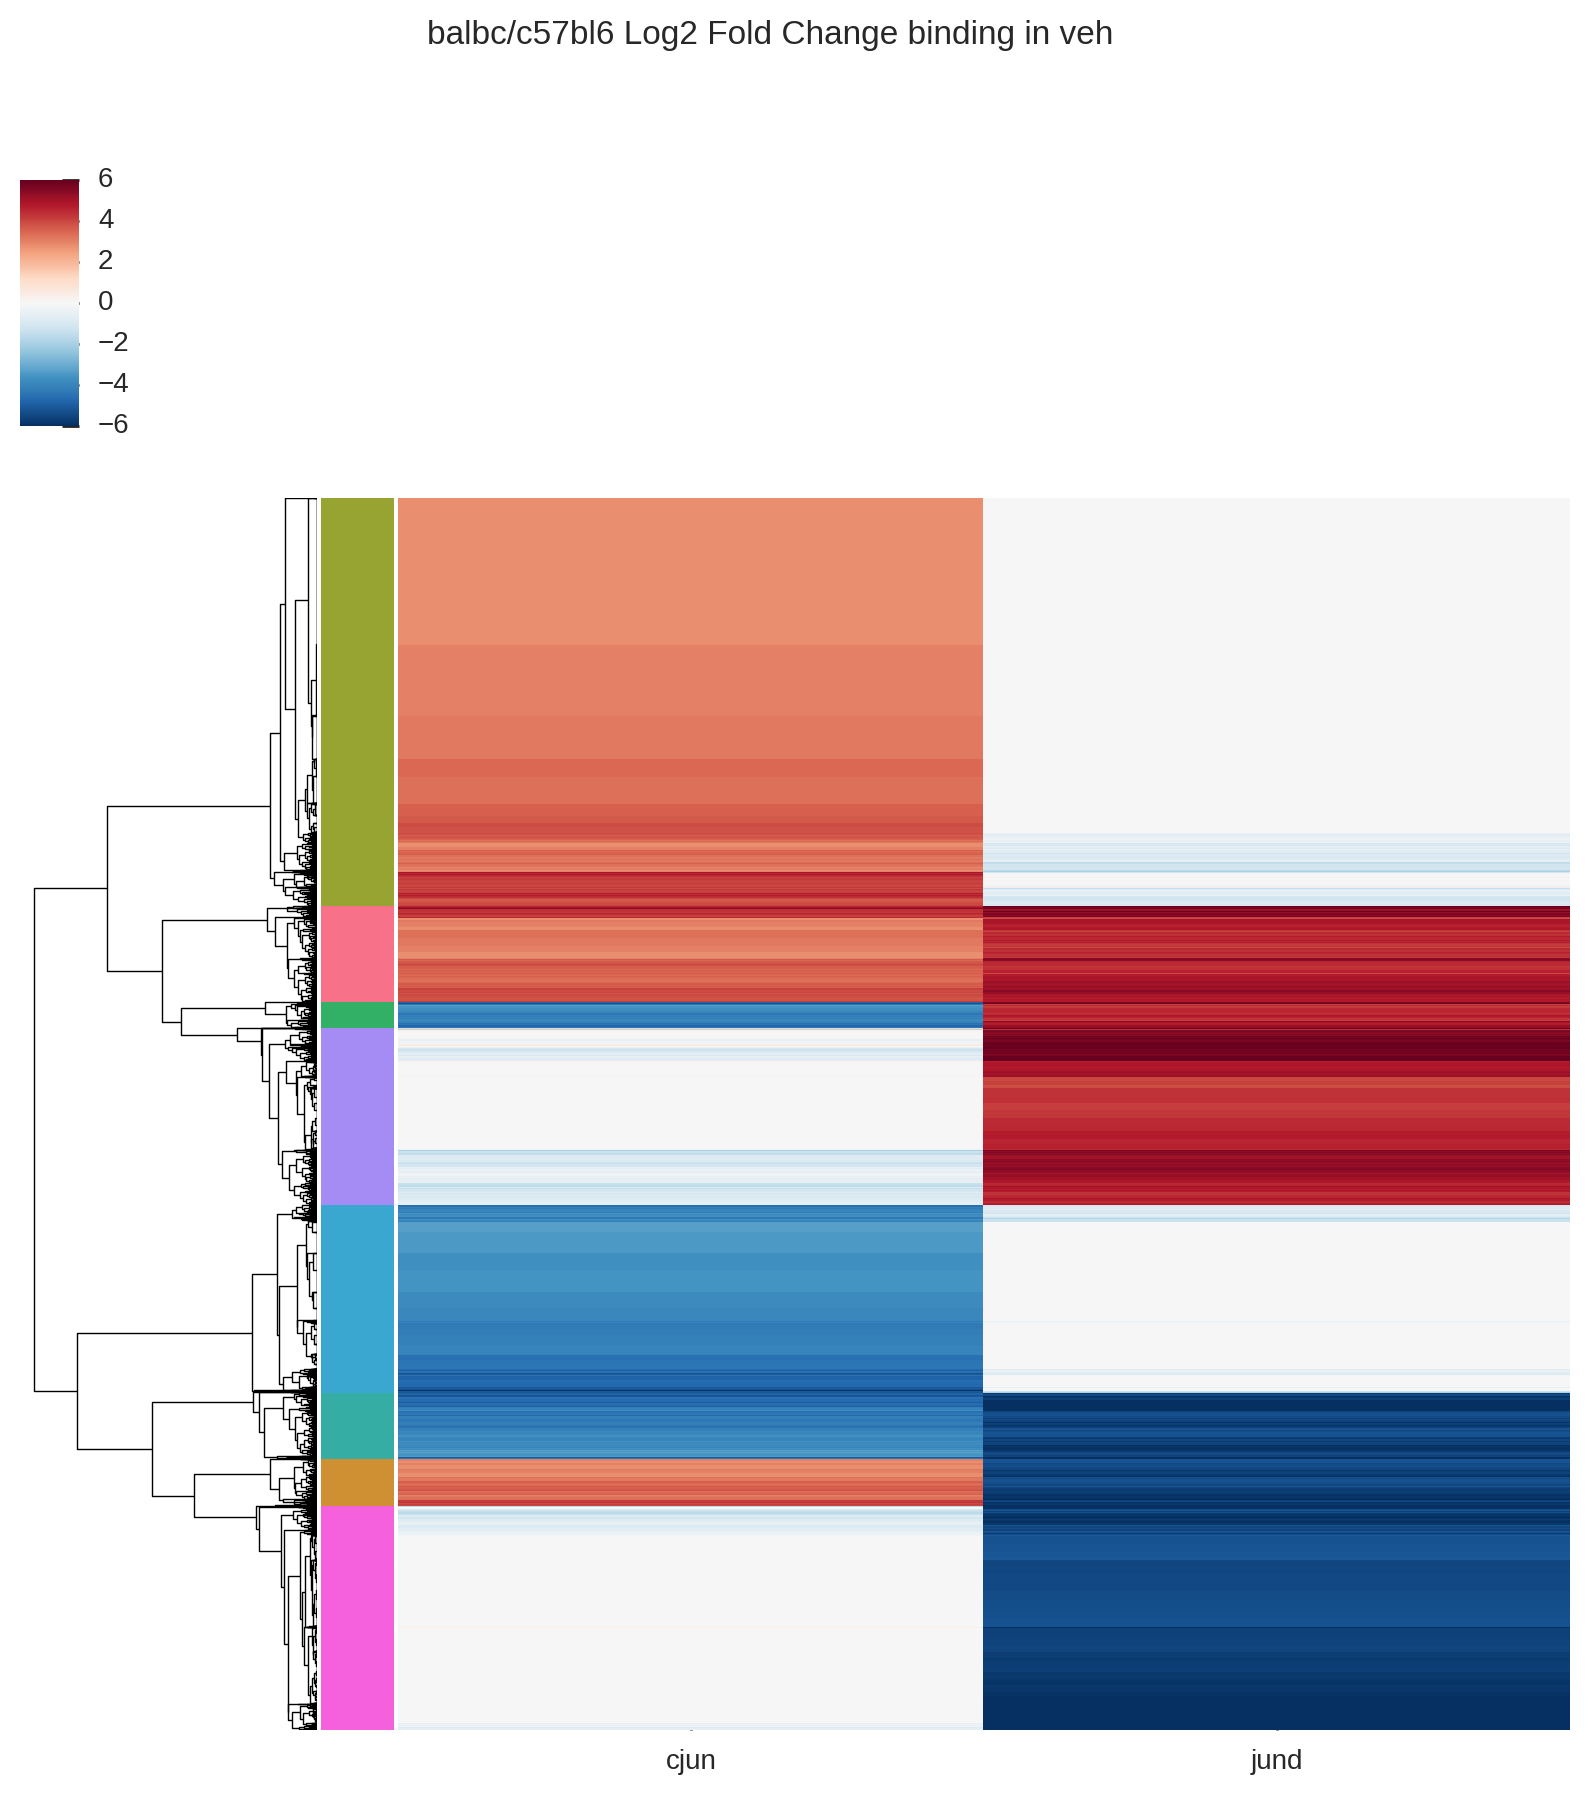

In [221]:
sns.clustermap(fold_frame,
              yticklabels=False,
              vmin=-6,
              vmax=6,
              row_colors = colors,
              col_cluster=False)
plt.suptitle(strain_2 + '/' + strain_1 + ' Log2 Fold Change binding in ' + condition)
plt.show()

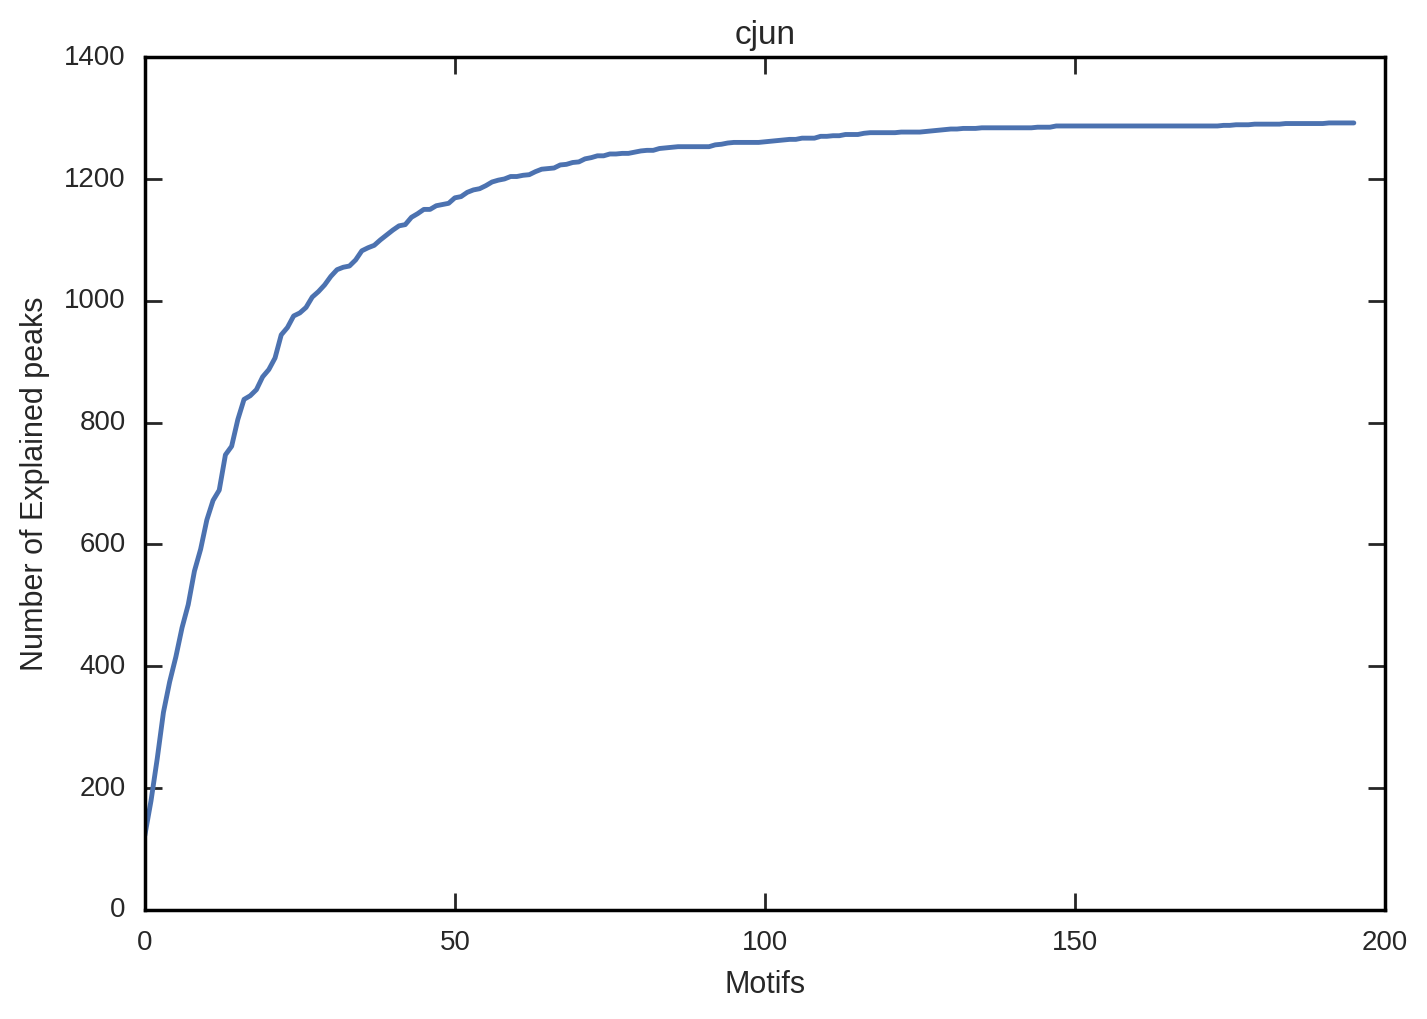

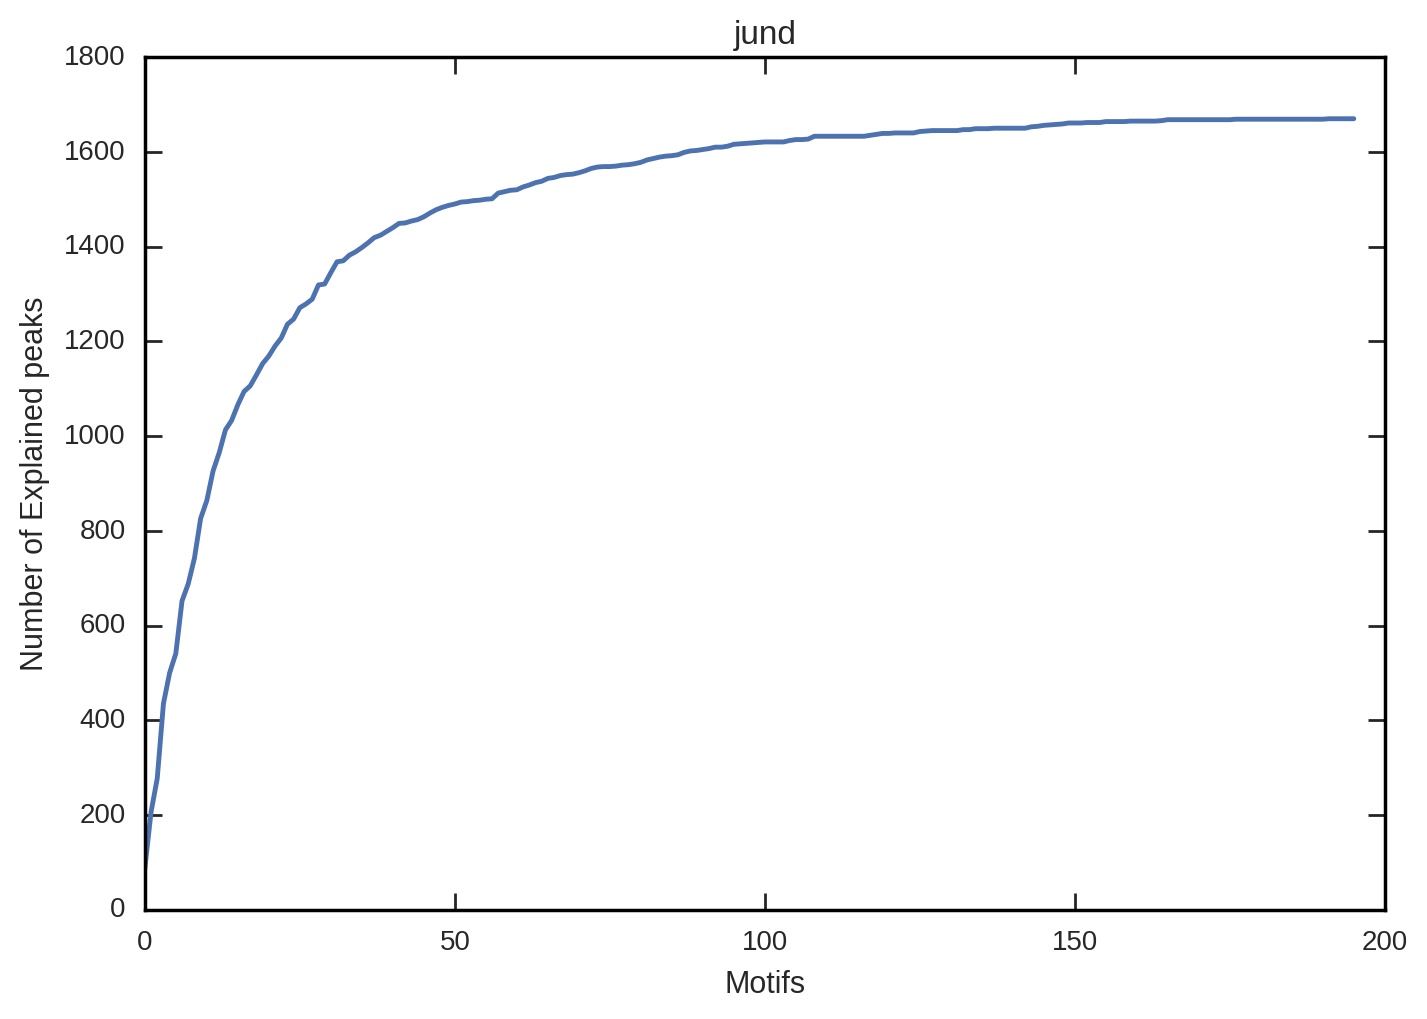

In [287]:
for factor in ['cjun', 'jund']:
    for state in ['c57bl6']:#, 'balbc']:
        indices = state_frame[state_frame[factor] == state].index.values
        current_snp_frame = motif_balbcj_snp_frame[motif_balbcj_snp_frame.index.isin(indices)]
        filtered_indices = current_snp_frame[current_snp_frame.sum(axis=1) > 0].index.values
        
        motif_weight_tuples = list(zip(coefficients_frame_veh_ind.index.values, coefficients_frame_veh_ind[factor].values))
        motif_weight_tuples = sorted(motif_weight_tuples, key=lambda x:x[1], reverse=True)
        seen_ids = set()
        explained_peaks = []
        labels = []
        for mwt in motif_weight_tuples:
            motif = mwt[0]
            weight = mwt[1]
            labels.append(motif + ' ('+ str(weight) +')')
            motif_indices = current_snp_frame[current_snp_frame[motif]>0].index.values
            seen_ids = seen_ids.union(set(motif_indices))
            explained_peaks.append(len(seen_ids))
        plt.plot(range(len(explained_peaks)), explained_peaks)
#         plt.xticks(range(len(explained_peaks)),labels)
        plt.xlabel('Motifs')
        plt.ylabel('Number of Explained peaks')
        plt.title(factor)
        plt.show()

In [285]:
labels[:20]

['atf7_batf3_creb5 (1.84199869865)',
 'ap-1 (1.65603101022)',
 'cebp (1.13412690412)',
 'xbp1 (1.05491428503)',
 'pax2 (0.776008004995)',
 'mef2a-b-d (0.649730710586)',
 'arntl_mitf (0.636058881384)',
 'mef2c (0.480983843819)',
 'maf_nrl (0.441576723492)',
 'bhlh (0.431221382829)',
 'hsf (0.425983796227)',
 'runx (0.416560336486)',
 'usf (0.416503329154)',
 'pax5 (0.402502609273)',
 'meis (0.388793496193)',
 'ar_nr3c1_nr3c2 (0.373971885569)',
 'mafg (0.366397289908)',
 'nfi (0.362881762986)',
 'ascl2_nhlh1 (0.358897003207)',
 'pax6 (0.353177148725)']

In [270]:
motif_weight_tuples

[('atf7_batf3_creb5', 1.8419986986458996),
 ('ap-1', 1.6560310102195714),
 ('cebp', 1.1341269041217357),
 ('xbp1', 1.0549142850294106),
 ('pax2', 0.77600800499531419),
 ('mef2a-b-d', 0.64973071058601606),
 ('arntl_mitf', 0.63605888138372457),
 ('mef2c', 0.48098384381887571),
 ('maf_nrl', 0.44157672349189397),
 ('bhlh', 0.43122138282944239),
 ('hsf', 0.42598379622693161),
 ('runx', 0.41656033648585772),
 ('usf', 0.41650332915379323),
 ('pax5', 0.40250260927255699),
 ('meis', 0.38879349619322967),
 ('ar_nr3c1_nr3c2', 0.37397188556915023),
 ('mafg', 0.36639728990776493),
 ('nfi', 0.36288176298645858),
 ('ascl2_nhlh1', 0.35889700320666557),
 ('pax6', 0.35317714872463091),
 ('pou6f2', 0.35258633986061971),
 ('rfx', 0.33908172349646393),
 ('rreb1', 0.33861036549042461),
 ('pou4', 0.30351285549171153),
 ('t', 0.28801453019703754),
 ('hoxb5_hoxd3', 0.28575405220808758),
 ('pknox_tgif', 0.27912921341597641),
 ('ebf1', 0.27723074161027306),
 ('duxa', 0.27376232564916919),
 ('esr2', 0.26904468441

unchanged c57bl6


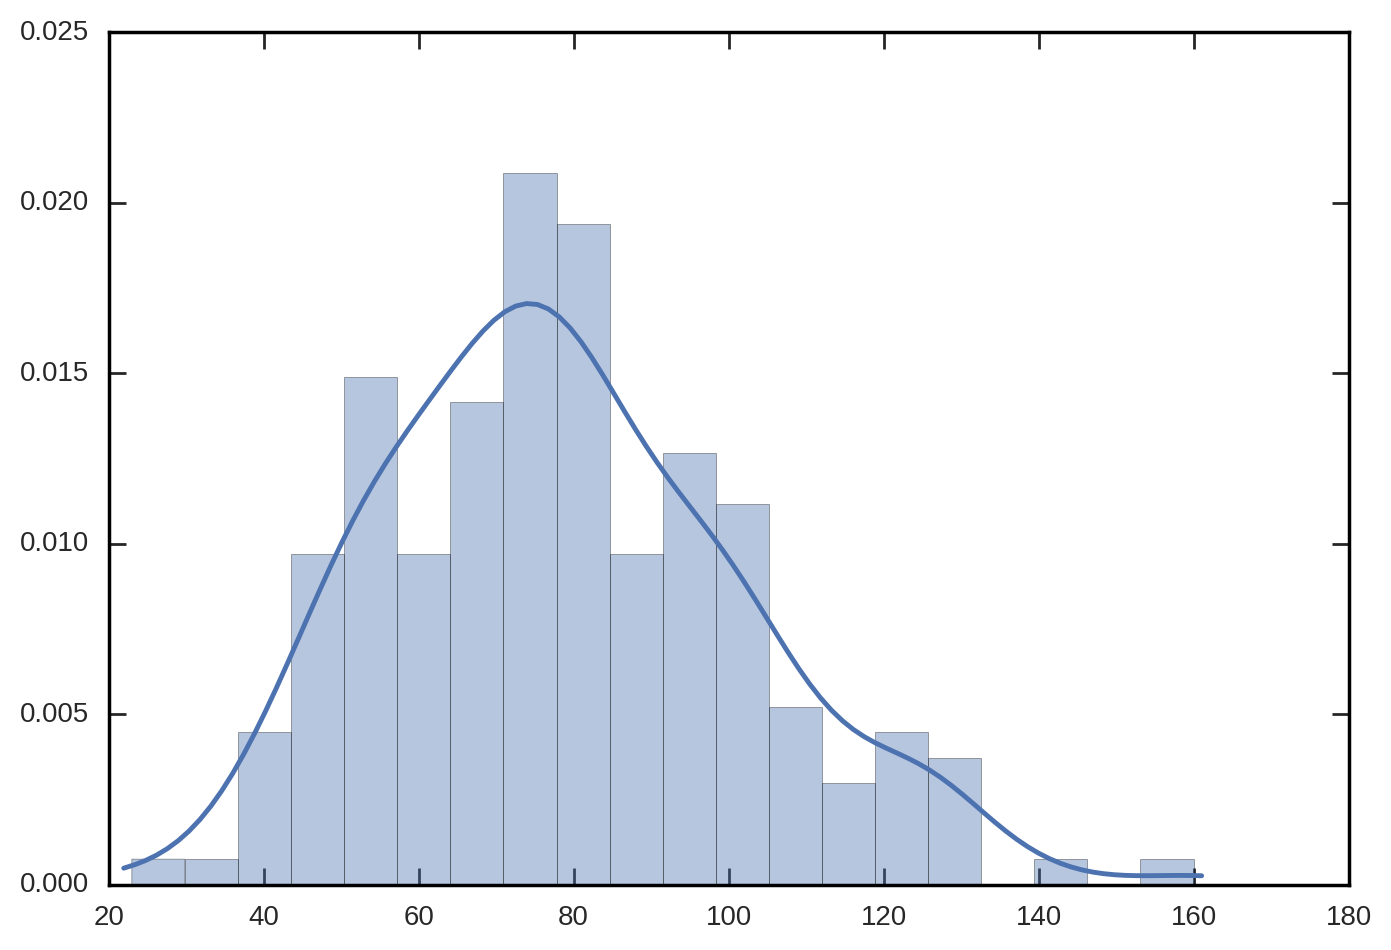

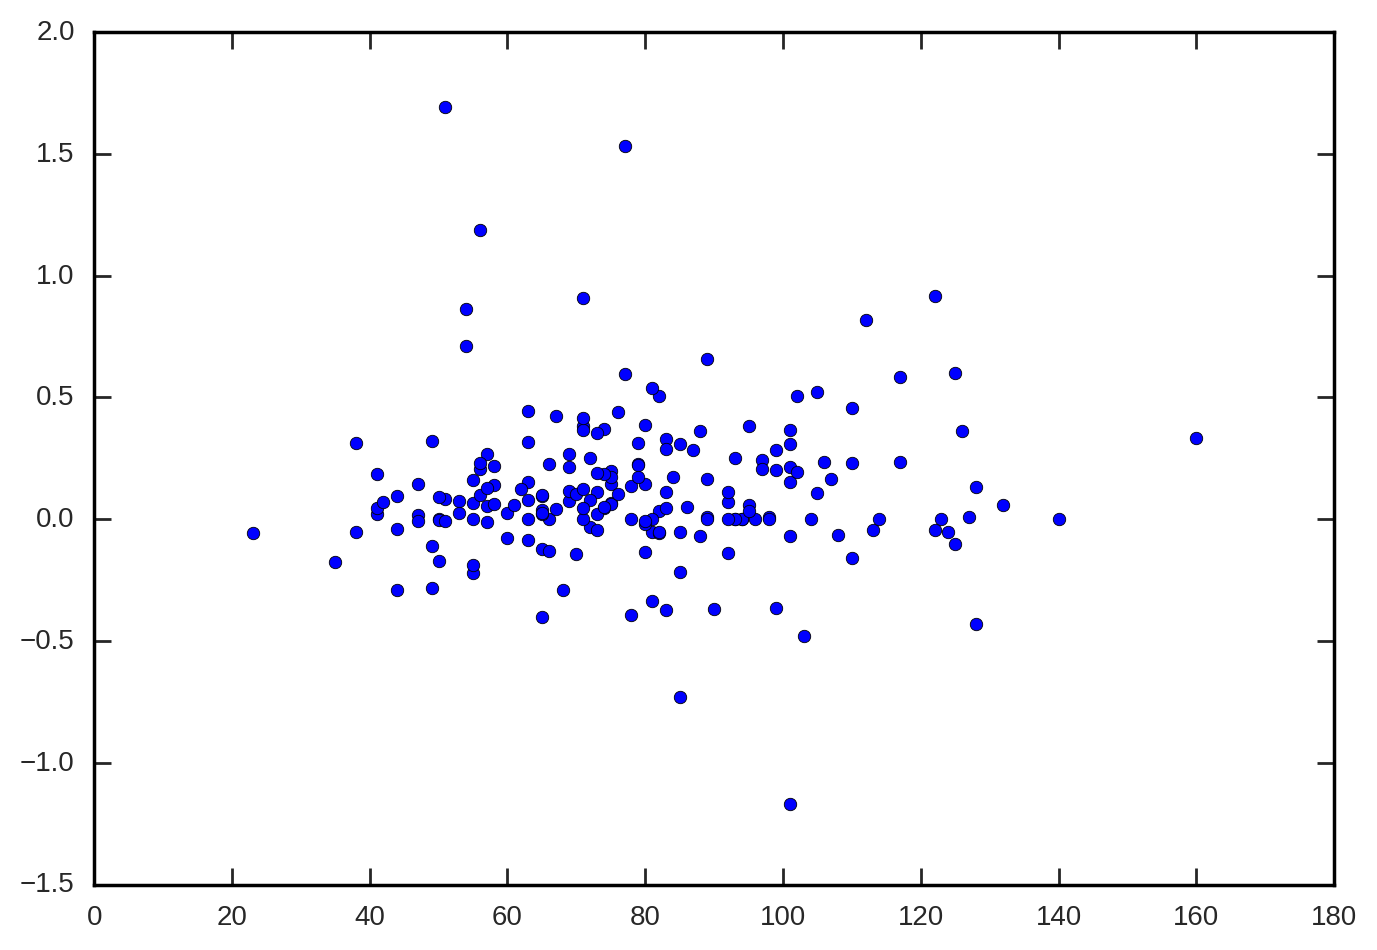

4200 1077


In [254]:
# for state in state_set:
for state in ['unchanged c57bl6']:
    print(state)
    indices = state_frame[state_frame['state'] == state].index.values
    current_frame = motif_balbcj_snp_bool_frame[motif_balbcj_snp_bool_frame.index.isin(indices)]
    filtered_indices = current_frame[current_frame.sum(axis=1) > 0].index.values
    motif_counts = motif_balbcj_snp_bool_frame[motif_balbcj_snp_bool_frame.index.isin(filtered_indices)].sum(axis=0)
    sns.distplot(motif_counts.values, bins=20)
    plt.show()
    plt.scatter(motif_counts.values, coefficients_frame_veh_ind['jund'])
    plt.show()
    print(len(indices),len(filtered_indices))
    

In [256]:
np.sum([x[0] for x in list(zip(motif_counts.values, coefficients_frame_veh_ind['jund'])) if x[1] > 0.5])

1375

### For C57Bl6 and Nod

In [ ]:

strains_factors = ['cjun', 'jund']
strain_1 = 'c57bl6'
strain_2 = 'nod'
condition = 'veh'
comparison_indices = set()
for x in range(len(strains_factors)):

    factor = strains_factors[x]
    strain_1_indices = set(summary_frame[summary_frame[strain_1 + '_' + factor + '_' + condition] > 0].index.values)
    strain_2_indices = set(summary_frame[summary_frame[strain_2 + '_' + factor + '_' + condition] > 0].index.values)

    comparison_indices = comparison_indices.union(strain_1_indices)
    comparison_indices = comparison_indices.union(strain_2_indices)

current_frame = summary_frame[summary_frame.index.isin(comparison_indices)]

strain_1_frame = current_frame[[strain_1 + '_' + f + '_' + condition for f in strains_factors]]
strain_2_frame = current_frame[[strain_2 + '_' + f + '_' + condition for f in strains_factors]]

fold_frame = np.log2(pd.DataFrame((strain_2_frame.values+1)).divide((strain_1_frame.values+1)))

fold_frame.columns = strains_factors
print(strain_1, strain_2, condition, fold_frame.shape)
sns.clustermap(fold_frame,
              yticklabels=False,
              vmin=-4,
              vmax=4,
              col_cluster=False)
plt.suptitle(strain_2 + '/' + strain_1 + ' Log2 Fold Change binding in ' + condition)
plt.show()

## Clustering Peaks according to important motifs

In [ ]:
### vehicle peaks ###
threshold =2
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_veh = set()
std = np.std(coefficients_frame_veh.values)
mean = np.mean(coefficients_frame_veh.values)
for factor in coefficients_frame_veh.columns.values:
    weights = coefficients_frame_veh[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_veh.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

In [ ]:
treatment = 'veh'
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6_')) &
                              (summary_frame['Factors'].str.contains(treatment))].index.values

for factor in ['ap-1', 'cebpa', 'pu1']:
    print(factor)
    factor_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+ factor + '_' + treatment)].index.values
    
    data = normed_motif_frame[normed_motif_frame.index.isin(factor_indices)][factor_motifs_dict[factor]]
    print(data.shape, len(factor_indices))
#     colors = ['blue' if x in factor_indices else 'grey' for x in c57bl6_indices]
    sns.clustermap(data=data, 
                   yticklabels=False,
                   col_cluster = False,
                   )
    plt.show()

### KLA

In [ ]:
### KLA peaks ###
threshold = 2.0
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}

significant_motifs_kla = set()
# mean = np.mean(coefficients_frame_kla.values)
# std = np.std(coefficients_frame_kla.values)

for factor in coefficients_frame_kla.columns.values:
    weights = coefficients_frame_kla[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

In [ ]:
treatment = 'kla'
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6_')) &
                              (summary_frame['Factors'].str.contains(treatment))].index.values

for factor in ['pu1', 'ap-1', 'p65']:
    print(factor)
    factor_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+ factor + '_' + treatment)].index.values
    
    data = normed_motif_frame[normed_motif_frame.index.isin(factor_indices)][factor_motifs_dict[factor]]
    print(data.shape, len(factor_indices))
#     colors = ['blue' if x in factor_indices else 'grey' for x in c57bl6_indices]
    sns.clustermap(data=data, 
                   yticklabels=False,
                   col_cluster = False,
                   )
    plt.show()

### Combinations of Factors

In [ ]:
treatment = 'veh'
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6_')) &
                              (summary_frame['Factors'].str.contains(treatment))].index.values
color_dict = dict(zip(['ap-1', 'cebpa', 'pu1', ], sns.color_palette('colorblind')))
colors = []
for factor in ['ap-1', 'cebpa', 'pu1']:
    print(factor)
    factor_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+ factor + '_' + treatment)].index.values
    print(len(factor_indices))
    current_color = color_dict[factor]
    current_colors = [current_color if x in factor_indices else 'white' for x in c57bl6_indices]
    colors.append(current_colors)

data = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][sorted(significant_motifs_veh)]

    
sns.clustermap(data=data, 
               yticklabels=False,
               col_cluster = False,
               row_colors = colors
               )
plt.show()

In [ ]:
treatment = 'kla'
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6_')) &
                              (summary_frame['Factors'].str.contains(treatment))].index.values
color_dict = dict(zip( ['ap-1', 'cebpa', 'pu1', 'p65'], sns.color_palette('colorblind')))
colors = []
for factor in ['ap-1', 'cebpa', 'pu1', 'p65']:
    print(factor)
    factor_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+ factor + '_' + treatment)].index.values
    print(len(factor_indices))
    current_color = color_dict[factor]
    current_colors = [current_color if x in factor_indices else 'white' for x in c57bl6_indices]
    colors.append(current_colors)

data = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][sorted(significant_motifs_kla)]

    
sns.clustermap(data=data, 
               yticklabels=False,
               col_cluster = False,
               row_colors = colors
               )
plt.show()